<a href="https://colab.research.google.com/github/LM1997610/NN/blob/main/NN_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the dataset

In [1]:
! pip -q install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
dataset = load_dataset(path='Francesco/apex-videogame', split=["train[:700]", "validation", "test"])
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

[Dataset({
     features: ['image_id', 'image', 'width', 'height', 'objects'],
     num_rows: 700
 }),
 Dataset({
     features: ['image_id', 'image', 'width', 'height', 'objects'],
     num_rows: 415
 }),
 Dataset({
     features: ['image_id', 'image', 'width', 'height', 'objects'],
     num_rows: 691
 })]

In [5]:
dataset[2]

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 691
})

In [6]:
train_data = dataset[0]
test_data = dataset[2]

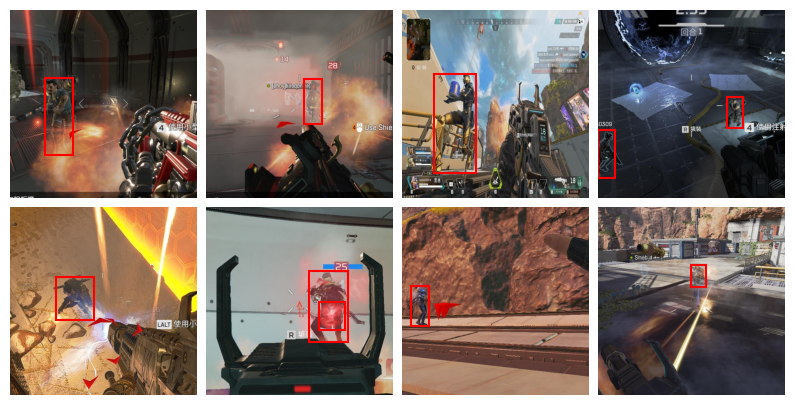

In [7]:
images_to_show = [5, 6, 10, 18, 25, 332, 567, 690]

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for image_n in range(len(images_to_show)):

  ax = axes[image_n // 4, image_n % 4]
  ax.imshow(test_data[images_to_show[image_n]]["image"], aspect = 'auto')
  ax.axis('off')

  for bbox in test_data[images_to_show[image_n]]['objects']['bbox']:
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

## Load the model

In [8]:
! pip install -q --upgrade keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 6.4 MB/s eta 0:00:00


In [9]:
import os

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization

Using TensorFlow backend


In [10]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset("yolo_v8_m_pascalvoc",
                                                              bounding_box_format="xywh")

100%|██████████| 2.27k/2.27k [00:00<00:00, 5.13MB/s]
100%|██████████| 99.5M/99.5M [00:02<00:00, 48.4MB/s]


In [11]:
inference_resizing = keras_cv.layers.Resizing(640, 640,
                                              pad_to_aspect_ratio=True,
                                              bounding_box_format="xywh")

In [12]:
imgs_to_try = []

for img_index in images_to_show:
  this_img = np.array(test_data[img_index]['image'])
  imgs_to_try.append(this_img)

image_batch = inference_resizing(imgs_to_try)

In [13]:
y_pred = pretrained_model.predict(image_batch)

1/1 [==============================] - 24s 24s/step


In [14]:
def get_bbox_and_confidence(data_pred, index):

  bounding_box = data_pred['boxes'][index]
  filtered_boxes = bounding_box[~np.all(bounding_box == -1, axis=1)]

  confidences = []
  for i in range(len(filtered_boxes)):
    this_conf = data_pred['confidence'][index][i]
    confidences.append(round(this_conf, 4))

  return {'boxes': filtered_boxes, 'confidence': confidences}

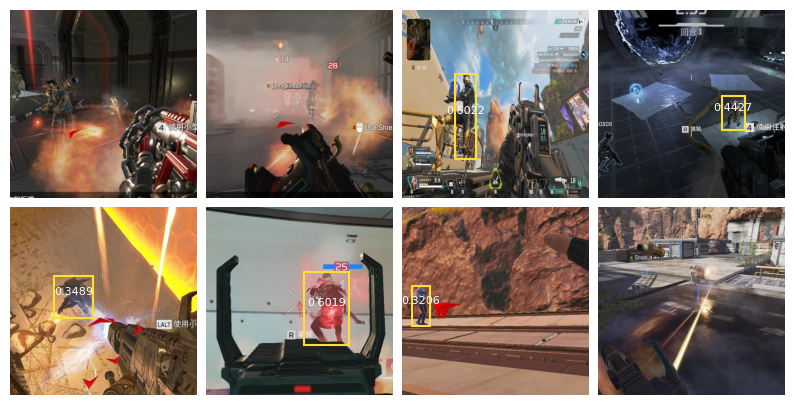

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for image_n in range(len(images_to_show)):

  ax = axes[image_n // 4, image_n % 4]
  ax.imshow(test_data[images_to_show[image_n]]["image"], aspect = 'auto')
  ax.axis('off')

  this_diz = get_bbox_and_confidence(y_pred, image_n)

  for bbox_idx in range(len(this_diz['boxes'])):
    x, y, w, h = this_diz['boxes'][bbox_idx]
    rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='#FFDD33', facecolor='none')
    ax.add_patch(rect)
    text = this_diz['confidence'][bbox_idx]
    ax.text(x+w/2, y+h/2, text, ha='center', va='bottom', color='white', fontsize=8)


plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [16]:
# train_data.features

In [17]:
import tensorflow as tf
from tqdm import tqdm
from PIL import Image

In [18]:
all_boxes = []
all_classes = []
all_images = []

for i in tqdm(range(len(train_data))):
  if len(train_data[i]['objects']['bbox']) == 1:
    all_boxes.append(train_data[i]['objects']['bbox'])
    all_classes.append(train_data[i]['objects']['category'])
    resized_image = train_data[i]['image'].resize((256, 256))
    all_images.append(np.array(resized_image))

100%|██████████| 700/700 [00:08<00:00, 78.79it/s]


In [19]:
labels = {"boxes": tf.constant(all_boxes, dtype = tf.float32),
          "classes": tf.constant(all_classes, dtype = tf.int64)}

In [20]:
tensore_unificato = tf.stack([arr for arr in all_images])
print(tensore_unificato.shape)

(567, 256, 256, 3)


In [30]:
# Train model
pretrained_model.compile(
    classification_loss='binary_crossentropy',
    box_loss='ciou',
    optimizer=tf.optimizers.SGD(global_clipnorm=10.0),
    jit_compile=False)

pretrained_model.fit(tensore_unificato, labels, epochs=100, verbose=2,  batch_size=32)

Epoch 1/100
18/18 - 34s - loss: 1.7548 - box_loss: 1.6867 - class_loss: 0.0681 - 34s/epoch - 2s/step
Epoch 2/100
18/18 - 8s - loss: 1.6539 - box_loss: 1.5877 - class_loss: 0.0662 - 8s/epoch - 436ms/step
Epoch 3/100
18/18 - 8s - loss: 1.5719 - box_loss: 1.4878 - class_loss: 0.0841 - 8s/epoch - 440ms/step
Epoch 4/100
18/18 - 8s - loss: 1.5859 - box_loss: 1.5213 - class_loss: 0.0646 - 8s/epoch - 437ms/step
Epoch 5/100
18/18 - 8s - loss: 1.5637 - box_loss: 1.5043 - class_loss: 0.0593 - 8s/epoch - 430ms/step
Epoch 6/100
18/18 - 8s - loss: 1.4791 - box_loss: 1.4222 - class_loss: 0.0569 - 8s/epoch - 428ms/step
Epoch 7/100
18/18 - 8s - loss: 1.4327 - box_loss: 1.3813 - class_loss: 0.0514 - 8s/epoch - 423ms/step
Epoch 8/100
18/18 - 8s - loss: 1.4703 - box_loss: 1.4161 - class_loss: 0.0542 - 8s/epoch - 422ms/step
Epoch 9/100
18/18 - 8s - loss: 1.3157 - box_loss: 1.2657 - class_loss: 0.0500 - 8s/epoch - 426ms/step
Epoch 10/100
18/18 - 8s - loss: 1.3033 - box_loss: 1.2537 - class_loss: 0.0496 - 8s

In [31]:
inference_resizing = keras_cv.layers.Resizing(640, 640,
                                              pad_to_aspect_ratio=True,
                                              bounding_box_format="xywh")

In [32]:
imgs_to_try = []

for img_index in images_to_show:
  this_img = np.array(test_data[img_index]['image'])
  imgs_to_try.append(this_img)

image_batch = inference_resizing(imgs_to_try)

In [33]:
y_pred = pretrained_model.predict(image_batch)

1/1 [==============================] - 3s 3s/step


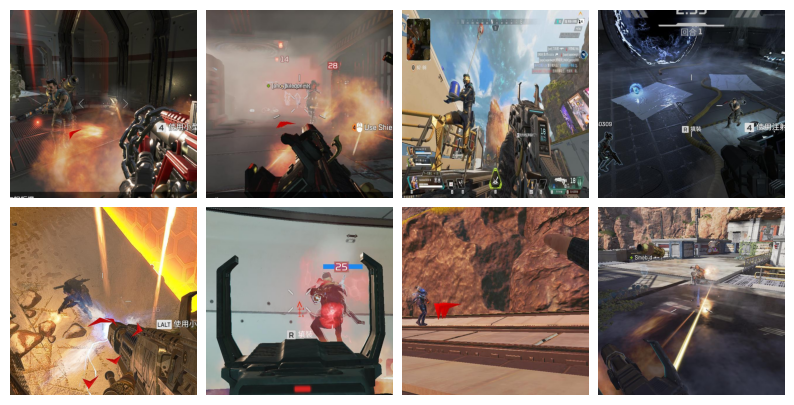

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for image_n in range(len(images_to_show)):

  ax = axes[image_n // 4, image_n % 4]
  ax.imshow(test_data[images_to_show[image_n]]["image"], aspect = 'auto')
  ax.axis('off')

  this_diz = get_bbox_and_confidence(y_pred, image_n)

  for bbox_idx in range(len(this_diz['boxes'])):
    x, y, w, h = this_diz['boxes'][bbox_idx]
    rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='#FFDD33', facecolor='none')
    ax.add_patch(rect)
    text = this_diz['confidence'][bbox_idx]
    ax.text(x+w/2, y+h/2, text, ha='center', va='bottom', color='white', fontsize=8)


plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()